In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline
## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
## 特征聚类的
from sklearn.cluster import KMeans

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
## 可视化
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [118]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [4]:
Train_data['power'] = Train_data['power'].map(lambda x: x if(x<600) else 600)
bin = [i*10 for i in range(61)]
Train_data['power_bin'] = pd.cut(Train_data['power'], bin, labels=False)
Train_data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [5]:
TestA_data['power'] = TestA_data['power'].map(lambda x: x if(x<600) else 600)
bin = [i*10 for i in range(61)]
TestA_data['power_bin'] = pd.cut(TestA_data['power'], bin, labels=False)
TestA_data[['power_bin', 'power']].head()

,power_bin,power
0,31.0,313
1,7.0,75
2,10.0,109
3,15.0,160
4,7.0,75


In [6]:
Train_data['model'].fillna(0,inplace=True)##众数填充只有一个

In [7]:
TestA_data['model'].fillna(0,inplace=True)

In [8]:
##根据生产日期和注册日期，合并整理得到 使用年限
Train_data['used_time_day'] = (pd.to_datetime(Train_data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(Train_data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
Train_data['used_time_month'] = round(Train_data['used_time_day'] / 30)
Train_data['used_time_year'] = round(Train_data['used_time_day'] / 365)

In [9]:
TestA_data['used_time_day'] = (pd.to_datetime(TestA_data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(TestA_data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
TestA_data['used_time_month'] = round(TestA_data['used_time_day'] / 30)
TestA_data['used_time_year'] = round(TestA_data['used_time_day'] / 365)

In [10]:
Train_data['notRepairedDamage'].replace('-', np.nan , inplace=True)

In [11]:
TestA_data['notRepairedDamage'].replace('-', np.nan , inplace=True)

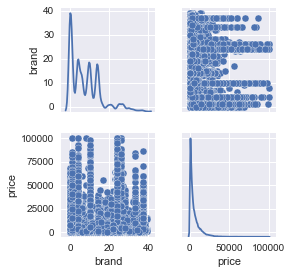

In [59]:

sns.set()
columns = ['brand', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

In [60]:
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(Train_data[columns])
p_ture = estimator.predict(Train_data[columns])
Train_data['brand_Kmeans'] = p_ture

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

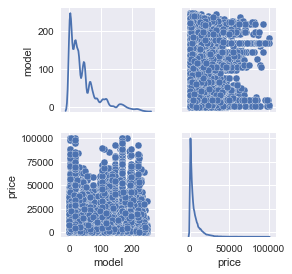

In [61]:
sns.set()
columns = ['model', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

In [62]:
columns = ['model', 'price']
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(Train_data[columns])
p_ture = estimator.predict(Train_data[columns])
Train_data['model_Kmeans'] = p_ture

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(Train_data[columns])
p_ture = estimator.predict(Train_data[columns])
Train_data['model_Kmeans'] = p_ture

In [17]:
Train_data['gearbox'].fillna(0,inplace=True)

In [18]:
Train_data['power_bin'].fillna(10.0,inplace=True)

In [19]:
Train_data['used_time_day'].fillna(4771,inplace=True)

In [63]:
columns = ['v_0','v_12']
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(Train_data[columns])
p_ture = estimator.predict(Train_data[columns])
Train_data['v0_v12'] = p_ture

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [64]:
columns = ['v_2','v_14']
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(Train_data[columns])
p_ture = estimator.predict(Train_data[columns])
Train_data['v2_v14'] = p_ture

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 35 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                150000 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    125676 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [13]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'power_bin', 'used_time_day', 'used_time_month',
       'used_time_year'],
      dtype='object')

In [14]:
TestA_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14', 'power_bin', 'used_time_day', 'used_time_month',
       'used_time_year'],
      dtype='object')

In [15]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
categorical_cols = Train_data.select_dtypes(include = 'object').columns
feature_cols = [col for col in numerical_cols if col not in ['SaleID','used_time_month','used_time_year','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

In [16]:
Train_data[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
gearbox          144019 non-null float64
power            150000 non-null int64
kilometer        150000 non-null float64
v_0              150000 non-null float64
v_1              150000 non-null float64
v_2              150000 non-null float64
v_3              150000 non-null float64
v_4              150000 non-null float64
v_5              150000 non-null float64
v_6              150000 non-null float64
v_7              150000 non-null float64
v_8              150000 non-null float64
v_9              150000 non-null float64
v_10             150000 non-null float64
v_11             150000 non-null float64
v_12             150000 non-null float64
v_13             150000 non-null float64
v_14             150000 non-null float64
power_bin        137171 non-null float64
used_time_day    138653 non-null float64
dtypes: float64(19), int64(1)
memory usage: 22.9 MB


In [17]:
X_data = Train_data[feature_cols]
Y_data = Train_data['price']
#X_test = TestA_data[feature_cols]
print('X train shape:',X_data.shape)
#print('X test shape:',X_data.shape)

X train shape: (150000, 20)


In [22]:
X_data.replace(to_replace = '-', value = np.nan, inplace = True)
X_data.fillna(X_data.median(),inplace= True)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

In [24]:
x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,test_size = 0.2)

In [23]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_data.values)
x = min_max_scaler.transform(X_data.values)
#x_ = min_max_scaler.transform(data_test[tags].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
model = keras.Sequential([
        keras.layers.Dense(250,activation='relu',input_shape=[20]), 
        keras.layers.Dense(250,activation='relu'), 
        keras.layers.Dense(250,activation='relu'), 
        keras.layers.Dense(250,activation='relu'), 
        keras.layers.Dense(1)])
model.compile(loss='mean_absolute_error',
                optimizer='Adam')

In [30]:
model.fit(x_train,y_train,batch_size = 2048,epochs=100)

Epoch 1/100
120000/120000 [==============================] - 2s 18us/sample - loss: 4660.4469
Epoch 2/100
120000/120000 [==============================] - 2s 15us/sample - loss: 2199.3053
Epoch 3/100
120000/120000 [==============================] - 2s 15us/sample - loss: 1967.9153
Epoch 4/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1830.9605s - loss: 183
Epoch 5/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1709.3583
Epoch 6/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1615.0990
Epoch 7/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1515.6577
Epoch 8/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1421.8176
Epoch 9/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1398.9152
Epoch 10/100
120000/120000 [==============================] - 2s 16us/sample - loss: 1351.3146
Epoch 11/100
120000/120000 [==================

120000/120000 [==============================] - 2s 16us/sample - loss: 738.4554
Epoch 88/100
120000/120000 [==============================] - 2s 15us/sample - loss: 704.6360
Epoch 89/100
120000/120000 [==============================] - 2s 16us/sample - loss: 727.2690
Epoch 90/100
120000/120000 [==============================] - 2s 15us/sample - loss: 670.6910
Epoch 91/100
120000/120000 [==============================] - 2s 15us/sample - loss: 720.9465
Epoch 92/100
120000/120000 [==============================] - 2s 16us/sample - loss: 766.9703
Epoch 93/100
120000/120000 [==============================] - 2s 16us/sample - loss: 678.1547
Epoch 94/100
120000/120000 [==============================] - 2s 16us/sample - loss: 707.0748
Epoch 95/100
120000/120000 [==============================] - 2s 17us/sample - loss: 676.8951
Epoch 96/100
120000/120000 [==============================] - 2s 19us/sample - loss: 711.9258
Epoch 97/100
120000/120000 [==============================] - 2s 17us/sam

In [11]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 22 columns):
gearbox            144019 non-null float64
power              150000 non-null int64
kilometer          150000 non-null float64
v_0                150000 non-null float64
v_1                150000 non-null float64
v_2                150000 non-null float64
v_3                150000 non-null float64
v_4                150000 non-null float64
v_5                150000 non-null float64
v_6                150000 non-null float64
v_7                150000 non-null float64
v_8                150000 non-null float64
v_9                150000 non-null float64
v_10               150000 non-null float64
v_11               150000 non-null float64
v_12               150000 non-null float64
v_13               150000 non-null float64
v_14               150000 non-null float64
power_bin          137171 non-null float64
used_time_day      138653 non-null float64
used_time_month    138653 non-n

In [137]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
gearbox          48090 non-null float64
kilometer        50000 non-null float64
v_0              50000 non-null float64
v_1              50000 non-null float64
v_2              50000 non-null float64
v_3              50000 non-null float64
v_4              50000 non-null float64
v_5              50000 non-null float64
v_6              50000 non-null float64
v_7              50000 non-null float64
v_8              50000 non-null float64
v_9              50000 non-null float64
v_10             50000 non-null float64
v_11             50000 non-null float64
v_12             50000 non-null float64
v_13             50000 non-null float64
v_14             50000 non-null float64
power_bin        45805 non-null float64
used_time_day    46246 non-null float64
dtypes: float64(19)
memory usage: 7.2 MB


In [24]:
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    #pred_x = xgr.predict(X_test.values)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)
print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [26]:
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

Train lgb...
MAE of val with lgb: 624.8829036679689


In [141]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = pred_x
sub.to_csv('./sub_used_car.csv',index=False)